In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageFile

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, \
    GlobalAveragePooling2D, Input, Multiply, Reshape, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import ResNet152, EfficientNetB7 #(EfficientNetB4-B7, Inception-v3, Xception)for getting high
from tensorflow.keras.regularizers import l2
import tensorflow_hub as hub
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
def clean_invalid_images(directory):
    for root, _, files in os.walk(direcrtory):
        for file in files:
            file_path= os.path.join(root, file)
            try:
                with image.open(file_path) as img:
                    img.verify()
            except (IOError, syntexError):
                print(f"Removing corrupted file: {file_path}")
                os.remove(file_path)

data= "/kaggle/input/rice-leaf-diseases-detection/Rice_Leaf_AUG/Rice_Leaf_AUG"
classes= sorted([folder for folder in os.listdir(data) if os.path.isdir(os.path.join(data,folder))])

In [3]:
classes

['Bacterial Leaf Blight',
 'Brown Spot',
 'Healthy Rice Leaf',
 'Leaf Blast',
 'Leaf scald',
 'Narrow Brown Leaf Spot',
 'Neck_Blast',
 'Rice Hispa',
 'Sheath Blight']

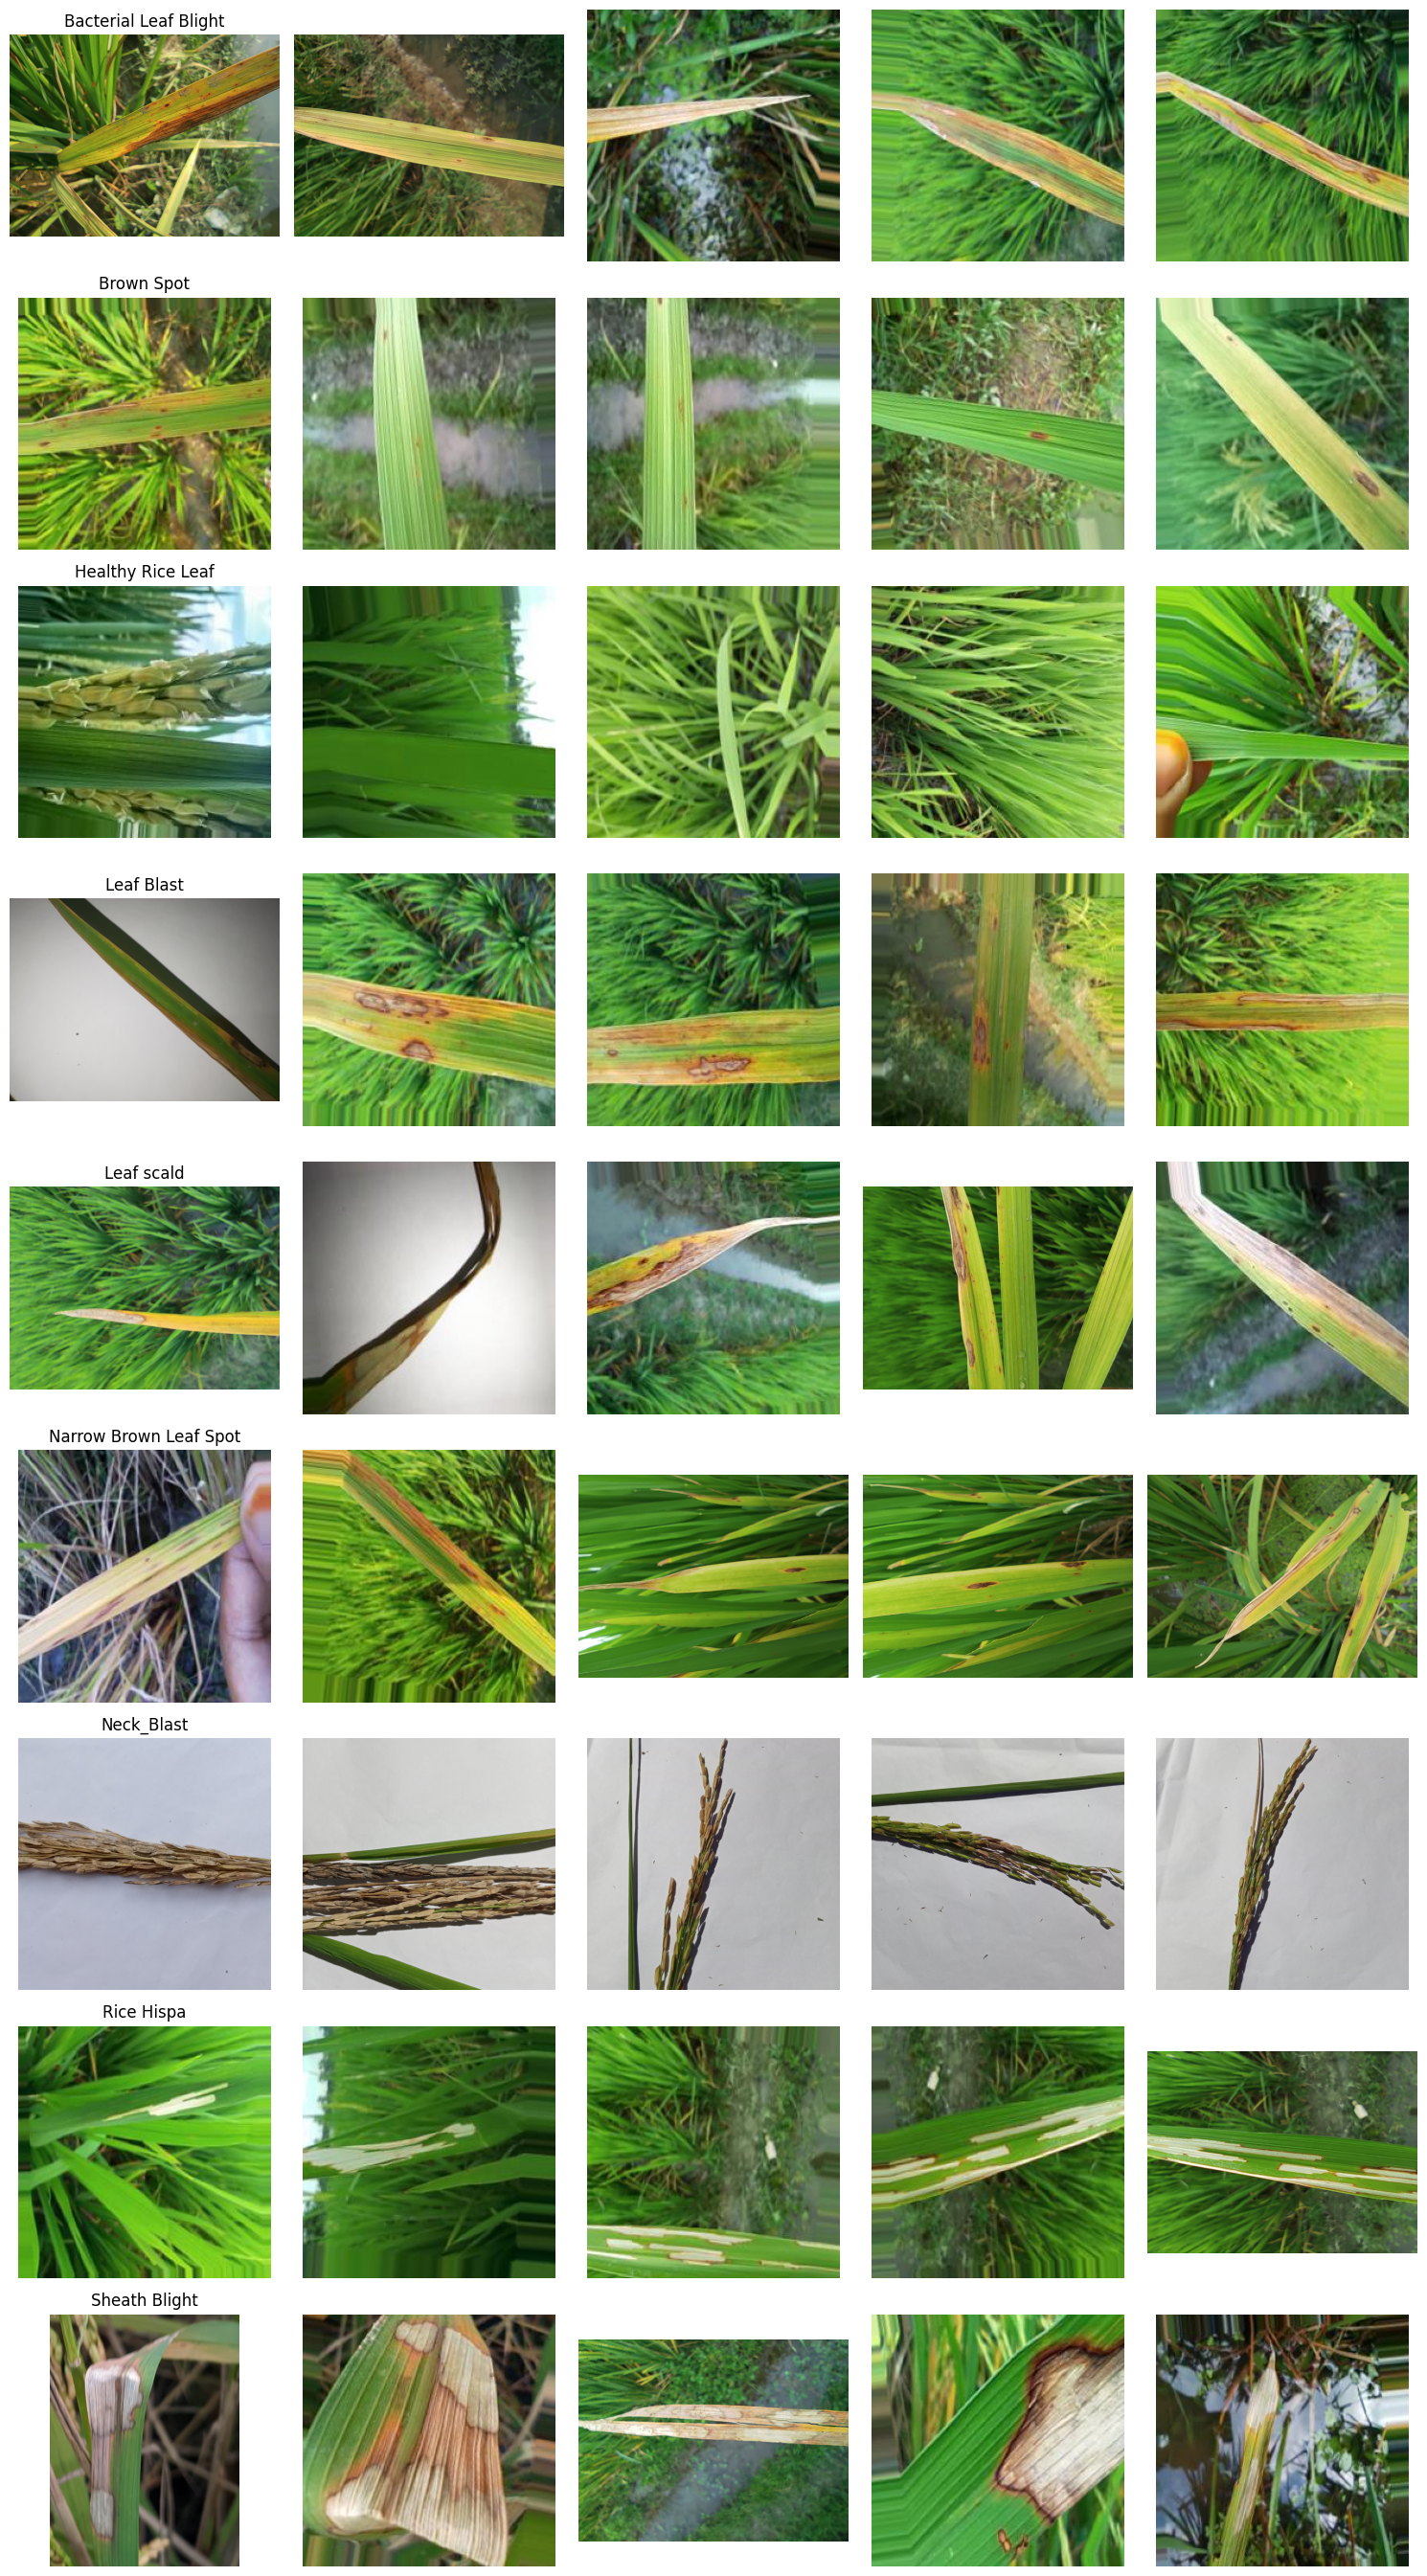

In [4]:
def visualize_images(data, classes, num_images=5):
    plt.figure(figsize=(15, len(classes) * 3)) 
    
    for idx, cls in enumerate(classes):
        class_path = os.path.join(data, cls)
        images = [os.path.join(class_path, img) for img in os.listdir(class_path) if img.endswith(('.png', '.jpg', '.jpeg'))]

        for i, img_path in enumerate(images[:num_images]):
            plt.subplot(len(classes), num_images, idx * num_images + i + 1)
            img = Image.open(img_path)
            plt.imshow(img)
            plt.axis('off')
            if i == 0:
                plt.title(cls, fontsize=12)

    plt.tight_layout()
    plt.show()
visualize_images(data, classes, num_images=5)

In [5]:
for class_name in os.listdir(data):
    class_path = os.path.join(data, class_name)
    if os.path.isdir(class_path):
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            with Image.open(image_path) as img:
                print(f"Image: {image_name}, Class: {class_name}, Shape: {img.size}")
            break 

Image: IMG20201109165822_00.jpg, Class: Neck_Blast, Shape: (3120, 3120)
Image: IMG_20231014_172242.jpg, Class: Leaf scald, Shape: (1600, 1200)
Image: Sheath_Blight (60).jpg, Class: Sheath Blight, Shape: (589, 786)
Image: aug_0_7183.jpg, Class: Healthy Rice Leaf, Shape: (224, 224)
Image: aug_0_2250.jpg, Class: Narrow Brown Leaf Spot, Shape: (224, 224)
Image: IMG_20231006_172820.jpg, Class: Leaf Blast, Shape: (1600, 1200)
Image: aug_0_8436.jpg, Class: Rice Hispa, Shape: (224, 224)
Image: aug_0_9604.jpg, Class: Brown Spot, Shape: (224, 224)
Image: IMG_20231018_144114.jpg, Class: Bacterial Leaf Blight, Shape: (1600, 1200)


In [6]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data,
    image_size=(224, 224), 
    batch_size=32,  
    label_mode='int'  #  'categorical' or 'binary' 
) 
dataset = dataset.map(lambda x, y: (x / 255.0, y))

iterator = iter(dataset)
images, labels = next(iterator)
print(images.shape, labels.shape)

Found 11790 files belonging to 9 classes.
(32, 224, 224, 3) (32,)


# spliting

In [7]:
train_size= int(len(dataset)*0.80)
test_size= int(len(dataset)*0.15)
val_size= int(len(dataset)*0.05)

In [8]:
train = dataset.take(train_size) 
val = dataset.skip(train_size).take(val_size) 
test = dataset.skip(train_size + val_size).take(test_size)

# a little bit augmentation 

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=30, width_shift_range=0.2, height_shift_range=0.2,
    shear_range=0.2, zoom_range=0.2, horizontal_flip=True, fill_mode='nearest'
)

# EfficientNet

In [10]:
input_tensor = Input(shape=(224, 224, 3))
base_model = EfficientNetB7(weights="imagenet", include_top=False, input_tensor=input_tensor)
base_model.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation="relu", kernel_regularizer=l2(0.01))(x)
x = Dropout(0.5)(x)
x = Dense(9, activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=SGD(learning_rate=1e-3, momentum=0.9, nesterov=True), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

258076736/258076736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │      1,728 │ stem_conv_pad[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        256 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        576 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        256 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 64)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 64)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 16)  │      1,040 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 64)  │      1,088 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 64)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      2,048 │ block1a_se_excit

 Total params: 65,557,280 (250.08 MB)

 Trainable params: 65,246,553 (248.90 MB)

 Non-trainable params: 310,727 (1.19 MB)

In [11]:
logdir = 'logs/efficientnet_b4'
tensorboard_callback = TensorBoard(log_dir=logdir, histogram_freq=1)

hist = model.fit(
    train,
    epochs=20,
    validation_data=val,
    callbacks=[tensorboard_callback]
)

Epoch 1/20


I0000 00:00:1732721952.186603     105 service.cc:145] XLA service 0x78f8b0009bf0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732721952.186661     105 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1732721952.186667     105 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1732722189.513179     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


295/295 ━━━━━━━━━━━━━━━━━━━━ 622s 1s/step - accuracy: 0.1330 - loss: 14.8652 - val_accuracy: 0.1545 - val_loss: 13.7502
Epoch 2/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.2510 - loss: 13.2333 - val_accuracy: 0.2049 - val_loss: 12.4747
Epoch 3/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.3361 - loss: 11.8043 - val_accuracy: 0.5122 - val_loss: 10.6808
Epoch 4/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.4599 - loss: 10.4328 - val_accuracy: 0.6007 - val_loss: 9.2285
Epoch 5/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 309s 1s/step - accuracy: 0.5659 - loss: 9.1592 - val_accuracy: 0.7309 - val_loss: 8.0686
Epoch 6/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.6617 - loss: 8.0257 - val_accuracy: 0.7847 - val_loss: 7.1036
Epoch 7/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 307s 1s/step - accuracy: 0.7296 - loss: 7.0714 - val_accuracy: 0.8576 - val_loss: 6.2471
Epoch 8/20
295/295 ━━━━━━━━━━━━━━━━━━━━ 308s 1s/step - accuracy: 0.8023 - loss: 6.2355 - val_accuracy

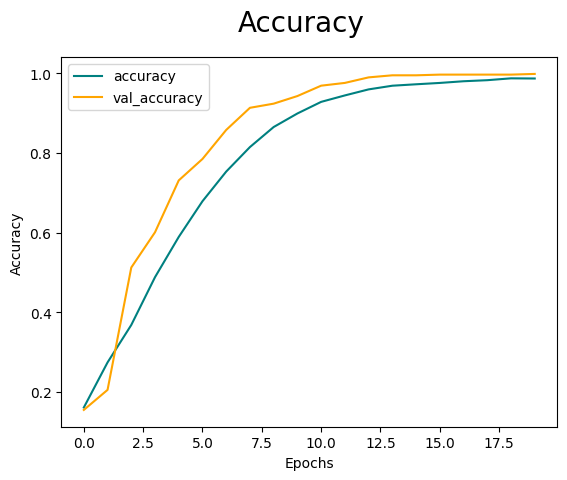

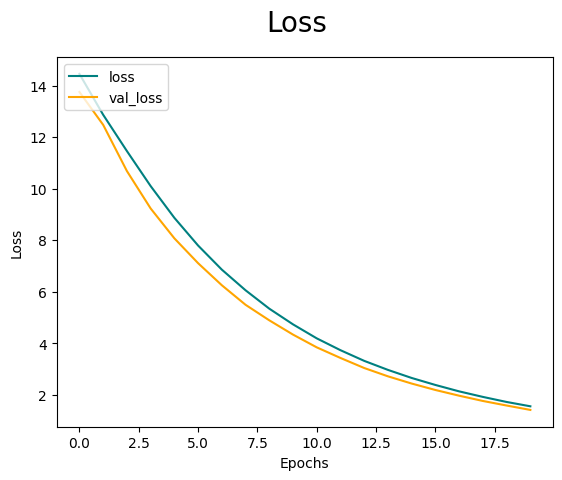

In [12]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Resnet152

In [13]:
input_tensor = Input(shape=(224, 224, 3))
base_model = ResNet152(weights="imagenet", include_top=False, input_tensor=input_tensor)
base_model.trainable = True

gap = GlobalAveragePooling2D()(base_model.output)
se = Dense(256, activation="relu")(gap)
se = Dense(base_model.output_shape[-1], activation="sigmoid")(se)
se = Reshape((1, 1, base_model.output_shape[-1]))(se)
se = Multiply()([base_model.output, se])
x = GlobalAveragePooling2D()(se)
x = Dense(1024, activation="relu", kernel_regularizer=l2(1e-4))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(107, activation="softmax", kernel_regularizer=l2(1e-4))(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=Adam(learning_rate=1e-4), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
model.summary()

234698864/234698864 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


NameError: name 'BatchNormalization' is not defined

In [ ]:
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()